## Import all libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
from itertools import chain
import warnings

import spacy
spacy.cli.download("en_core_web_sm")

import gender_guesser.detector as gender

from allennlp.predictors.predictor import Predictor
model_url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz"
predictor = Predictor.from_path(model_url)

data_folder = 'data/'

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


error loading _jsonnet (this is expected on Windows), treating C:\Users\alexi\AppData\Local\Temp\tmpvw12lgvo\config.json as plain json
Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Table of contents
1. [Load data](#loaddata)
    1. [Load CMU Movie Summary Corpus data](#CMUdata)
    2. [Load IMDb data](#IMDbdata)
2. [Data exploration of the movie metadata](#movie)
3. [Data exploration of the character metadata](#character)
4. [Data exploration of summaries](#summary)
5. [Summaries analysis pipeline](#pipeline)
    1. [Coreference resoltion using AllenNLP model](#coref)
    2. [Indentification of characters in the summary](#NER)

# Load data <a name="loaddata"></a>

## Load CMU Movie Summary Corpus data <a name="CMUdata"></a>

## Movies Metadata

In [3]:
#Load data and set indexes
movie_metadata = pd.read_csv(data_folder + "movie.metadata.tsv", sep='\t', header = None)
movie_metadata.columns = ['movie_ID','FB_ID','movie_name','release_date','box_office','length','languages','country','genres']

#Force float type to the movie ID column, set as index
movie_metadata.movie_ID = movie_metadata.movie_ID.astype(int)
movie_metadata = movie_metadata.set_index('movie_ID')

#Drop freebase database ID, we don't need it
movie_metadata = movie_metadata.drop(columns=['FB_ID'])

#Remove movies with non-defined release date
#Convert release date to datetime type, only keep year 
movie_metadata = movie_metadata[movie_metadata.release_date.notna()]
movie_metadata['release_date'] = movie_metadata.release_date.apply(lambda d:datetime.strptime(str(d[0:4]), "%Y"))
movie_metadata['release_date'] = [date.year for date in movie_metadata.release_date]

#Change release date 1010, it's a mistake movie actually release in 2010
movie_metadata = movie_metadata.replace(1010,2010)

#Clean languages, country, genres columns
movie_metadata['languages'] = [lang.split('"')[3::4] for lang in movie_metadata.languages]
movie_metadata['country'] = [lang.split('"')[3::4] for lang in movie_metadata.country]
movie_metadata['genres'] = [lang.split('"')[3::4] for lang in movie_metadata.genres]

movie_metadata.head(10)

,movie_name,release_date,box_office,length,languages,country,genres
movie_ID,,,,,,,
975900,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
13696889,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
18998739,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]"
10408933,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
9997961,Contigo y aquí,1974,NaN,NaN,[Spanish Language],[Argentina],"[Musical, Drama, Comedy]"


## Characters metadata

In [4]:
#Load character metadata
character_metadata = pd.read_csv(data_folder + "character.metadata.tsv", sep='\t', header=None)

#only keep movie_ID , name, gender, and age
character_metadata = character_metadata.iloc[:,[0,2,3,5,9]] 
character_metadata.columns = ['movie_ID','release_date','name','gender','age']
character_metadata.name = character_metadata['name'].astype(str)
character_metadata.movie_ID = character_metadata['movie_ID'].astype(int)
character_metadata = character_metadata.set_index('movie_ID')

#Change realease year to float indicading the year
character_metadata = character_metadata[character_metadata['release_date'].notna()]
character_metadata['release_date'] = character_metadata['release_date'].apply(lambda x : datetime.strptime(str(x)[0:4],"%Y"))
character_metadata['release_date'] = [date.year for date in character_metadata['release_date']] 
character_metadata = character_metadata.replace(1010, 2010)

#Drop the characters without gender defined
character_metadata = character_metadata[character_metadata.gender.notna()]

character_metadata.sample(10)

,release_date,name,gender,age
movie_ID,,,,
26333526,2009,Maître Walser,M,51.0
696180,1991,nan,F,NaN
6900343,1996,nan,M,70.0
11071821,1960,nan,M,34.0
27813251,2011,nan,F,NaN
5393201,1996,nan,M,43.0
26284549,1964,nan,F,36.0
5515243,2006,Truck Stop Patron,M,38.0
11453579,2007,nan,M,32.0


## Plot summaries

In [5]:
summary_file = open(data_folder + 'plot_summaries.txt', 'r', encoding="utf8")
summaries = summary_file.readlines()

#Separate summary and movie ID
summaries = pd.DataFrame([summ.split("\t") for summ in summaries], columns=['movie_ID','summary'])
summaries['summary'] = summaries.summary.replace(r'\n',' ', regex=True) #Remove /n at end of summaries
summaries['movie_ID'] = summaries['movie_ID'].astype(int)
summaries = summaries.set_index('movie_ID')

#Count number of words in each summary
def count_words_simple(x):
    return len(x.split(" "))

summaries['length'] = summaries['summary'].apply(count_words_simple)

summaries.head()

,summary,length
movie_ID,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",26
31186339,The nation of Panem consists of a wealthy Capi...,781
20663735,Poovalli Induchoodan is sentenced for six yea...,505
2231378,"The Lemon Drop Kid , a New York City swindler,...",854
595909,Seventh-day Adventist Church pastor Michael Ch...,398


## Load IMDb data <a name="IMDbdata"></a>

In [ ]:
# import imdb data
title_basics_imdb = pd.read_csv('./data_imdb/data.tsv', sep='\t', low_memory=False)

# drop nan values for the startYear
title_basics_imdb['startYear'] = title_basics_imdb['startYear'].replace('\\N', np.nan)
title_basics_imdb = title_basics_imdb.dropna()

# convert column startYear from string to float
title_basics_imdb['startYear'] = title_basics_imdb['startYear'].astype(float)

# remove data before 1885 and after 2014 in order to have comparable data with our dataset
title_basics_imdb.drop(title_basics_imdb[title_basics_imdb['startYear'] < 1885].index, inplace = True)
title_basics_imdb.drop(title_basics_imdb[title_basics_imdb['startYear'] > 2015].index, inplace = True)

# keep only movie and remove all other types of titles
title_basics_imdb = title_basics_imdb[title_basics_imdb['titleType'].str.contains('movie') == True][:]

In [ ]:
movie_metadata_imdb = title_basics_imdb[:]
# drop nan values from column genres 
movie_metadata_imdb['genres'] = title_basics_imdb['genres'].replace('\\N', np.nan)
movie_metadata_imdb = movie_metadata_imdb.dropna()

# split data in column genres in order to use function get_count_genre
movie_metadata_imdb['genres'] = [lang.split(',') for lang in movie_metadata_imdb.genres]

# drop nan values from the column runtimeMinutes
movie_metadata_imdb['runtimeMinutes'] = movie_metadata_imdb['runtimeMinutes'].replace('\\N', np.nan)

# Data exploration of the movie metadata <a name="movie"></a>

## Distibution of release data


The two graphs below represent the number of movies released per year in the CMU and IMBd datasets between 1885 and 2015. The trend of the two curves seems similar in the two datasets. 

Indeed, between 1885 and around 1910 almost only few movies are released. Next, between 1910 and the 90's there seems to be a fairly linear growth, with occasional slight decreases, in the number of films released. It is interesting to note that there is a decrease in the number of films released during the World War II period. Then, there is an exponential growth since the 1990s. The decrease after 2012 in the CMU dataset is due to the small number of movies in the dataset added after 2012. This motivates the sudden decrease because, unlike the IMDb dataset, CMU dataset does not contain all movies released after 2012. 
These graphs confirm that CMU dataset reflects a general trend of movie released.

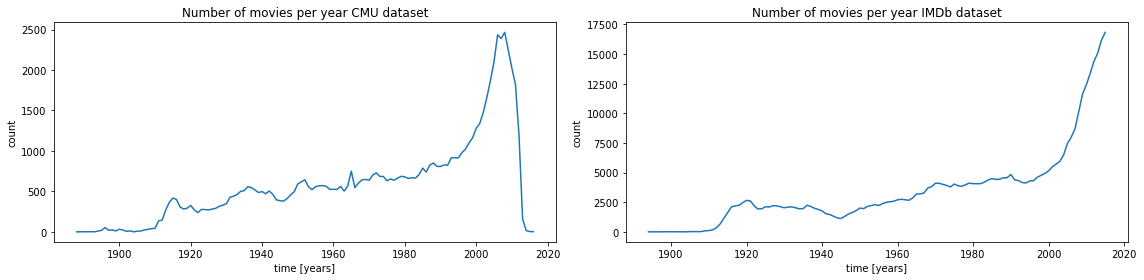

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

movie_metadata.groupby(by='release_date')['release_date'].count().plot(ax=ax1)
ax1.set_xlabel('time [years]')
ax1.set_ylabel('count')
ax1.set_title('Number of movies per year CMU dataset')

title_basics_imdb.groupby(by='startYear')['startYear'].count().plot(ax = ax2)
ax2.set_xlabel('time [years]')
ax2.set_ylabel('count')
ax2.set_title('Number of movies per year IMDb dataset')

plt.tight_layout()
plt.show()

## Which movie genres are the most frequent in the dataset?


Similarly to the comparison of movies released per year in CMU and IMDb datasets, the two graphs below represent the distribution of movie genres in the two datasets.

First, we compared the first main genres in the two datasets. With respect to the total number of movies in the two datasets, drama and comedies occupy the first and second place. Next, in the IMDb dataset the third position is occupied by documentaries. Nevertheless, since this category is not present in the CMU dataset the third position is occupied by romance movies, which lies in the IMDb dataset fourth position. Similarly, IMDb dataset does not have a category black and white movies.
Second, we noticed that in the first 10 common genres, action, thriller and crimes are present in both datasets.
We can thus note that the main genre categories are almost the same in the two datasets. This confirms that CMU dataset reflects a general movie genres distribution.


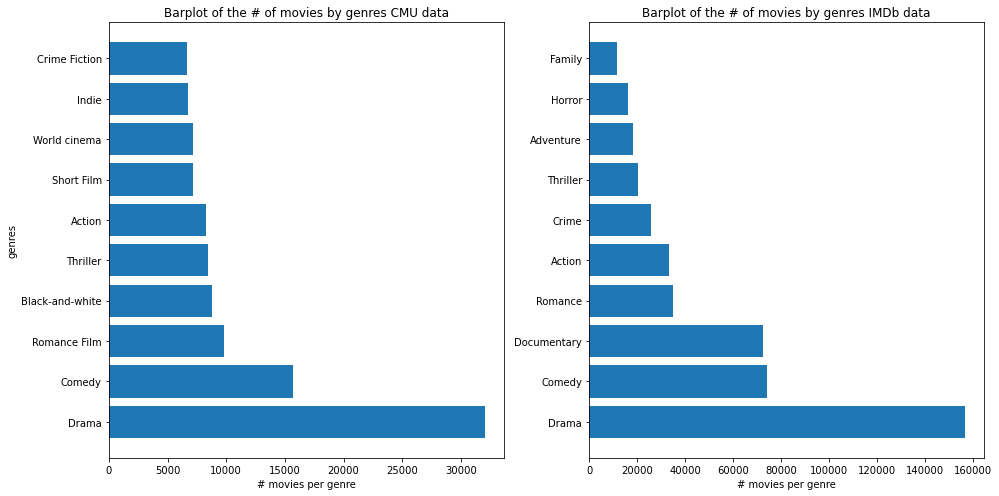

In [71]:
def get_count_genre(x):
    genre, count_genre = np.unique((list(chain.from_iterable(x))), return_counts=True)
    count_genre = pd.DataFrame({'genre': genre,'count': count_genre})
    return count_genre.sort_values(by=['count'], ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# count genre CMU data
count_genre = get_count_genre(movie_metadata.genres)

ax1.barh(count_genre.iloc[0:10].genre, count_genre.iloc[0:10]['count'])
ax1.set_xlabel('# movies per genre')
ax1.set_ylabel('genres')
ax1.set_title('Barplot of the # of movies by genres CMU data')

# count genre IMDb data
count_genre = get_count_genre(movie_metadata_imdb.genres)

ax2.barh(count_genre.iloc[0:10].genre, count_genre.iloc[0:10]['count'])
ax2.set_xlabel('# movies per genre')
ax2.set_title('Barplot of the # of movies by genres IMDb data')

plt.tight_layout()
plt.show()

## Is the distribution the same accross decades? 
We see that the top genres evolved through the decades, but this makes sense since movie trends and preferences certainly evolved with time. Moreover, tags such as black-and-white and silent movies disappear with the advance of technology. Nonetheless, some movies genres remain in the top accross almost all decades. For example, the genre drama, comedy, and action/adventure are very often present in the top 5 genres, which also seems to be the case in the IMDb dataset. Therefore, we conclude that the sample of movies in the CMU corpus reflects the actual distribution of genres of all movies.

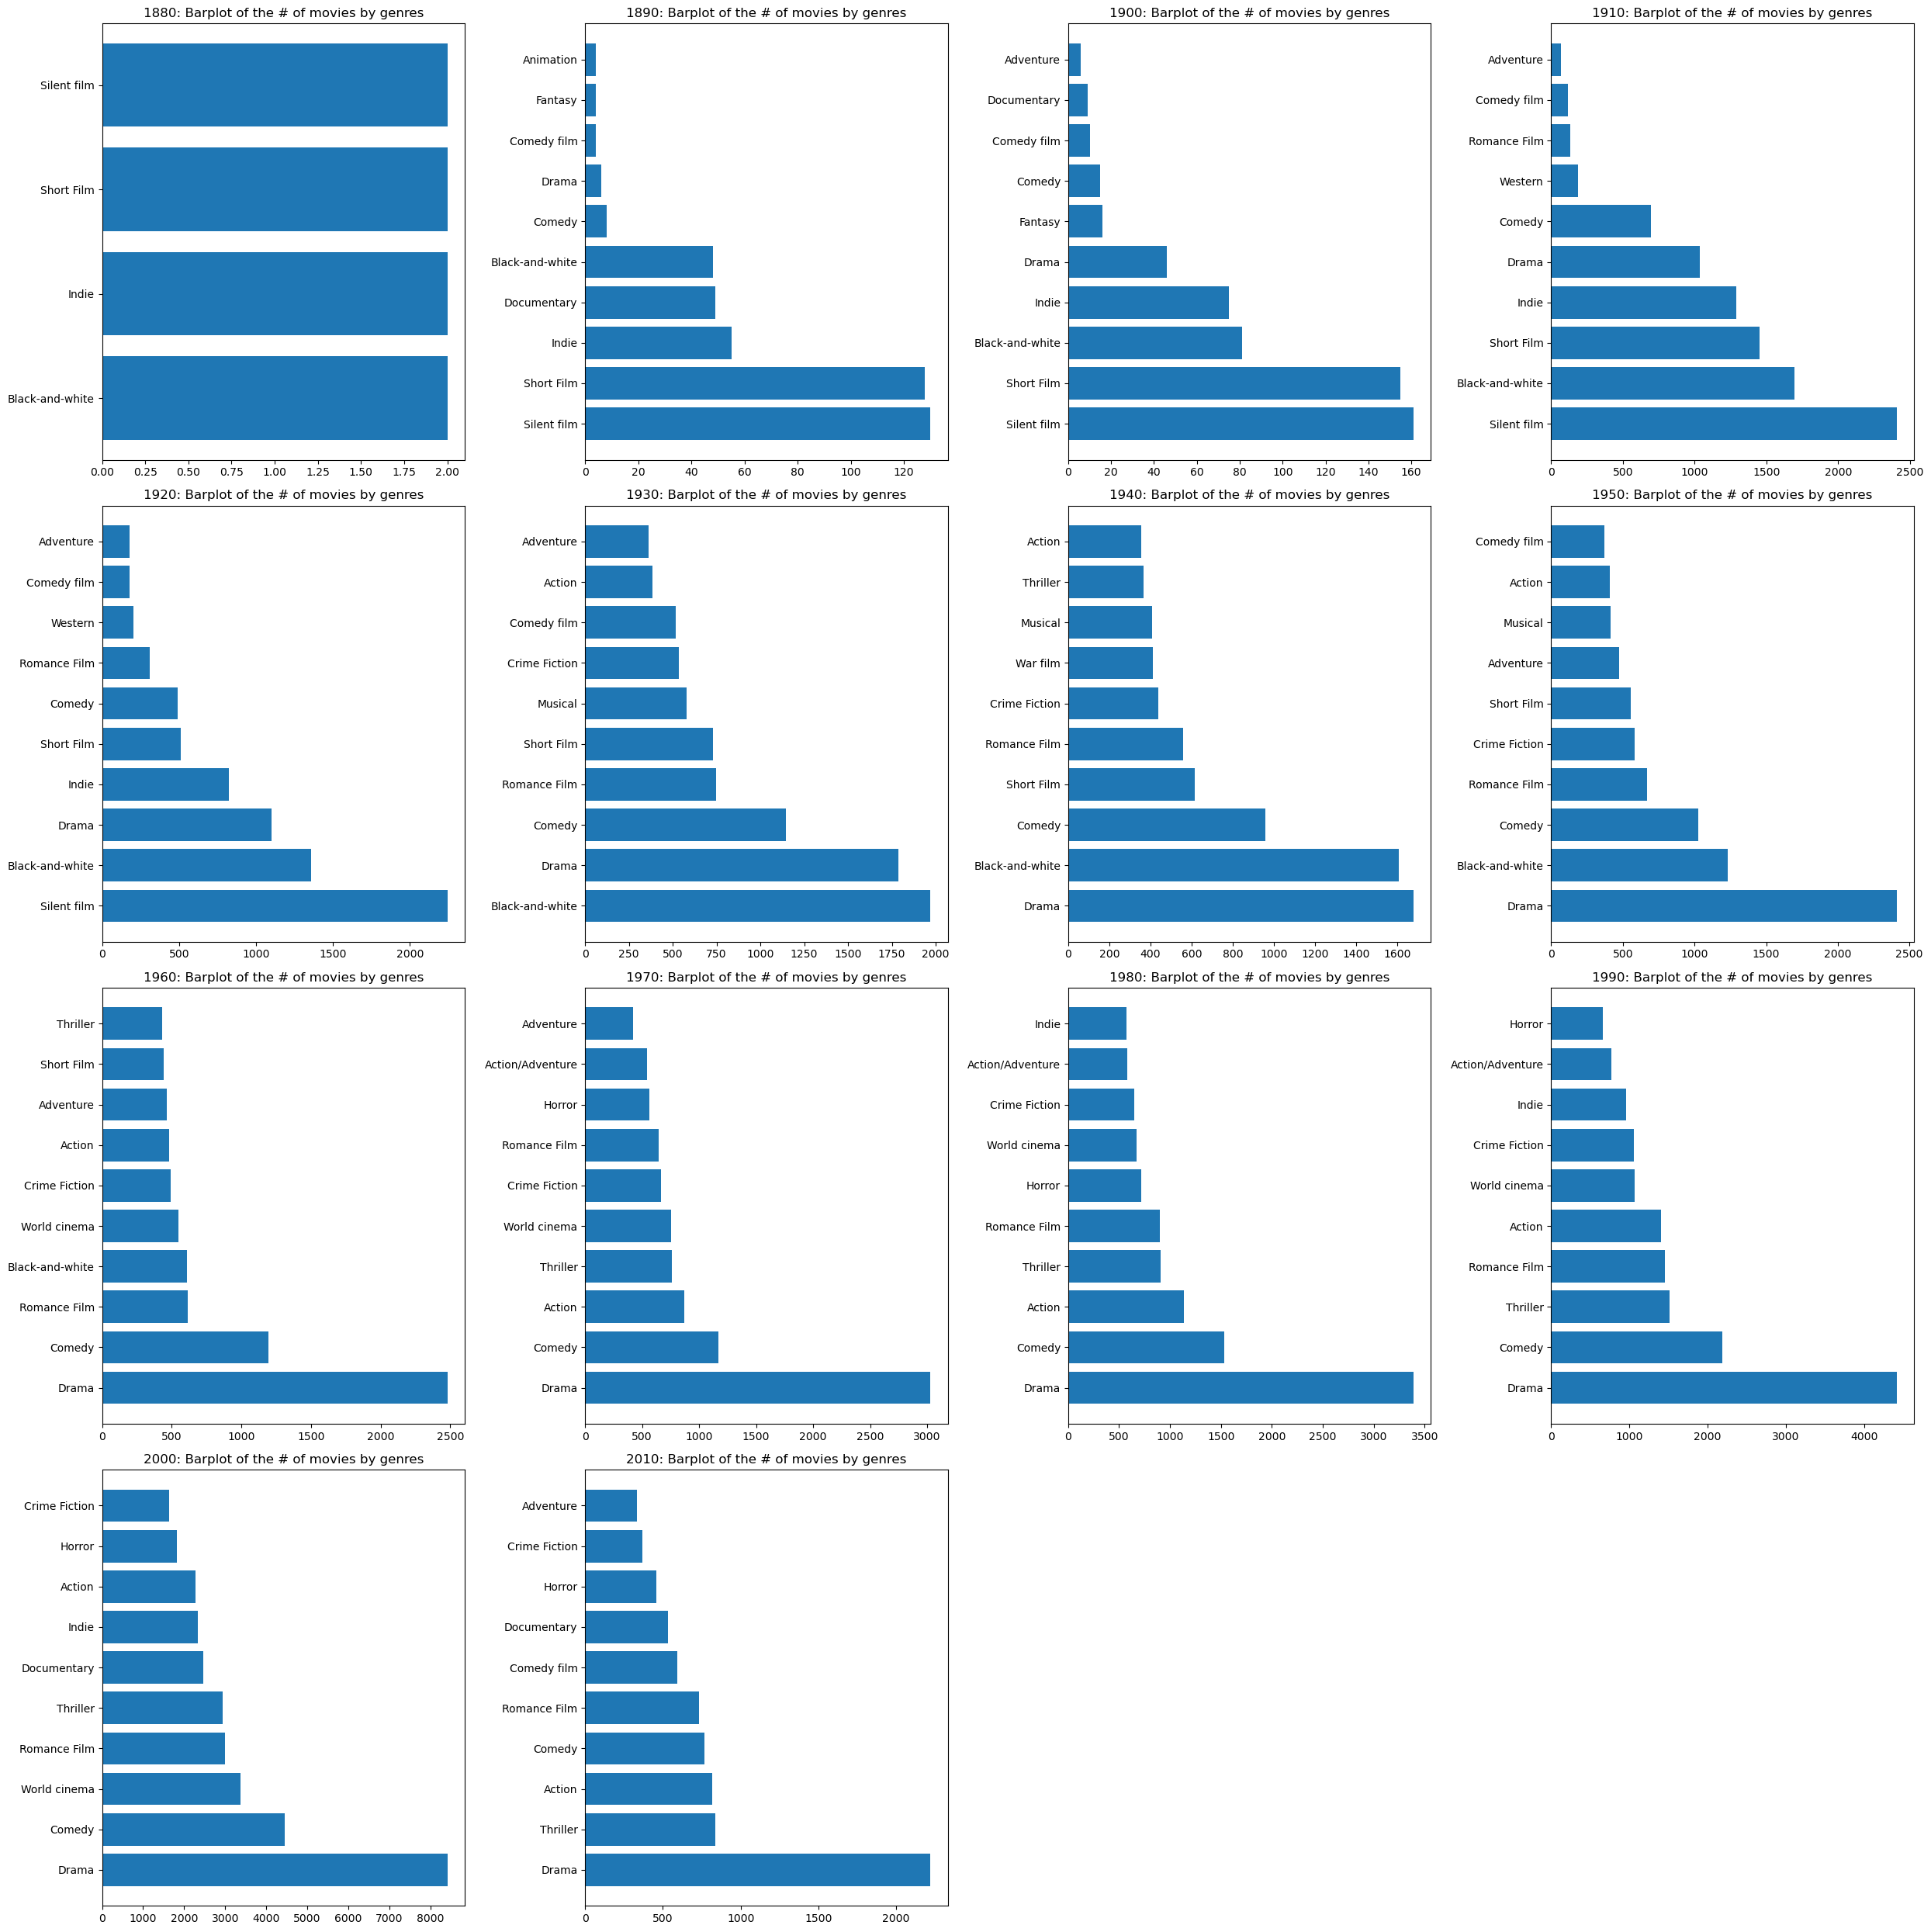

In [9]:
#Get count by decades
genre_count = movie_metadata.groupby((movie_metadata.release_date//10)*10).genres.apply(get_count_genre)

#Plot for each decade
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25,25))
axes = axes.flatten()
for i, decade in enumerate(np.unique(movie_metadata.release_date//10*10)):
    
    if (genre_count.loc[decade].shape[0] >= 10):
        axes[i].barh(genre_count.loc[decade]['genre'].iloc[0:10], genre_count.loc[decade]['count'].iloc[0:10])
    else:
        axes[i].barh(genre_count.loc[decade]['genre'].values, genre_count.loc[decade]['count'])
    
    axes[i].set_title(str(decade) + ': Barplot of the # of movies by genres')

fig.delaxes(axes[14]); fig.delaxes(axes[15])
plt.tight_layout()
plt.show()

## Where were produced the movies?

The countries of production in CMU corpus is very diverse. However, the top producer appears to be the US, followed by India, and the UK. As of 2010, the top 3 was in order India, USA and the UK [[1]].  But, since the movies were extracted from English wikipedia, it seems plausible that USA movies would be overrepresented. Indeed, about 20% of English wikipedia editors are from the USA, whereas only 3% are from India [[2]]. An editor from the USA will most likely write an article about a movie from the USA and not an Indian movie. This explains the overrepresentation of USA-produced movies.

Moreover, we decide here to only analyze the movies produced in the USA. Indeed, since we want to study the portrayal of women in movies and that gender equality issues are largely influenced by the culture, we will focus our analysis only on the USA to have a homegeous culture.

[1]: https://www.screenaustralia.gov.au/fact-finders/international-context/world-rankings/in-the-archive/films-produced
[2]: https://en.wikipedia.org/wiki/Wikipedia:Who_writes_Wikipedia%3F

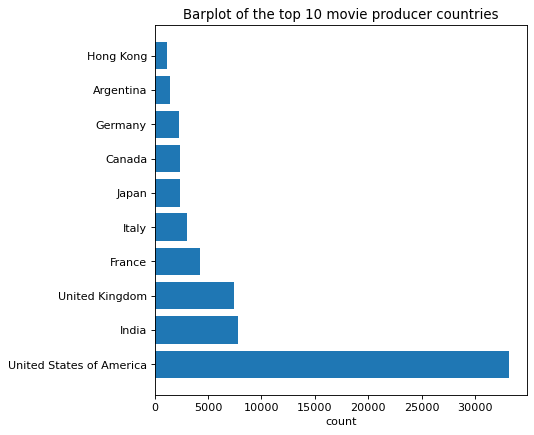

In [10]:
#Count for each country
country, count_country =  np.unique((list(chain.from_iterable(movie_metadata.country))),return_counts=True)
count_country = pd.DataFrame(count_country, index = country, columns=['count'])
count_country = count_country.sort_values(by=['count'], ascending=False)

#Let's only look at the top 10 producing movie country
plt.figure(figsize=(6, 6), dpi=80)
plt.barh(count_country.iloc[0:10].index, np.squeeze(count_country.iloc[0:10].values))
plt.xlabel('count'); plt.title('Barplot of the top 10 movie producer countries')
plt.show()

## Select only USA produced movies and release since 1940

In [23]:
def check_USA_produced(countries):
    return any('United States of America' in country for country in countries)

#Select only movies produced in the US
mask_usa = [check_USA_produced(x) for x in movie_metadata.country]
usa_movie = movie_metadata[mask_usa][:]

#Selecting only movies released after 1940
usa_movie.drop(usa_movie[usa_movie['release_date'] < 1940.0].index, inplace = True)

usa_movie.head()

,movie_name,release_date,box_office,length,languages,country,genres
movie_ID,,,,,,,
975900,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
6631279,Little city,1997,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,..."
77856,Mary Poppins,1964,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ..."
33420460,Keep the Change,1992,NaN,97.0,[English Language],[United States of America],[Drama]


# Data exploration character metadata focusing on gender

### Evolution of Female and Male 

,release_date,name,age
gender,,,
F,131312,131312,99246
M,263902,263902,191524


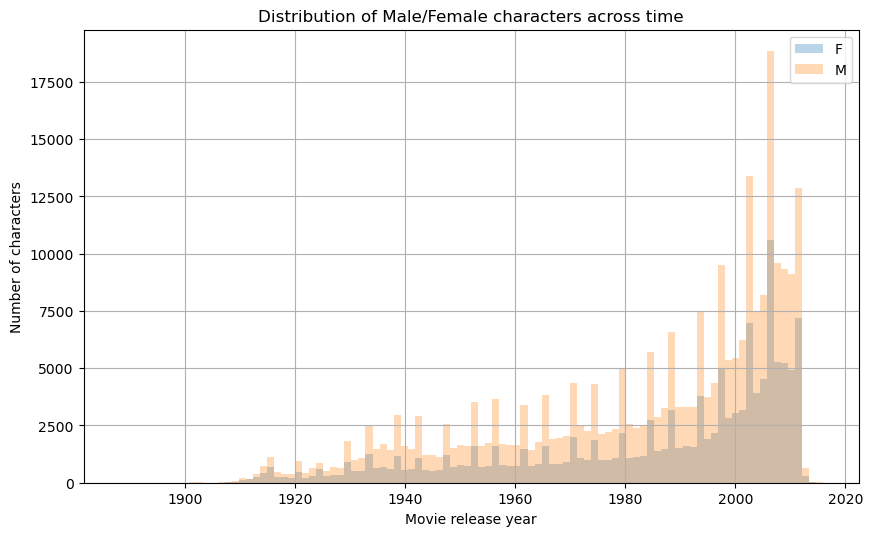

In [97]:
#General distribution of characters depending on gender 
fig = plt.figure(figsize = (10,6), dpi = 100)
display(character_metadata.groupby('gender').count())
character_metadata.groupby('gender')['release_date'].hist(alpha=0.3, bins=100, legend=True)
plt.ylabel('Number of characters')    
plt.xlabel('Movie release year')
plt.title("Distribution of Male/Female characters across time")
plt.show()

### Evolution of Female and Male in the USA since 1940

In [24]:
#Joining movie and character metadata
merged_charac = pd.merge(left = character_metadata, right = usa_movie['genres'], on = 'movie_ID', how = 'right')
#Selecting only movies released after 1940
#merged_charac.drop(merged_charac[merged_charac['release_date'] < 1940.0].index, inplace = True)
merged_charac.head(3)

,release_date,name,gender,age,genres
movie_ID,,,,,
975900,2001.0,Akooshay,F,42.0,"[Thriller, Science Fiction, Horror, Adventure,..."
975900,2001.0,Lieutenant Melanie Ballard,F,27.0,"[Thriller, Science Fiction, Horror, Adventure,..."
975900,2001.0,Desolation Williams,M,32.0,"[Thriller, Science Fiction, Horror, Adventure,..."


In [25]:
#Separating dataframe based on character gender
characters_F = merged_charac[merged_charac['gender'] == 'F']
characters_M = merged_charac[merged_charac['gender'] == 'M']

#Counting and sorting by release_date
Nb_charac_F = characters_F.groupby('release_date').count()
Nb_charac_M = characters_M.groupby('release_date').count()

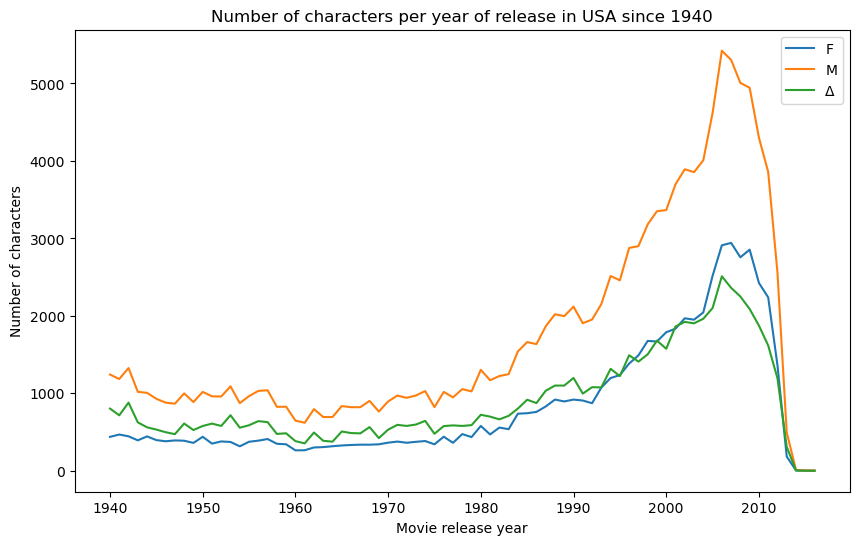

In [26]:
fig = plt.figure(figsize = (10,6), dpi = 100)
plt.plot(Nb_charac_F['name'], label = 'F')
plt.plot(Nb_charac_M['name'], label = 'M')
plt.plot(Nb_charac_M['name'] - Nb_charac_F['name'], label = '\u0394')
plt.title('Number of characters per year of release in USA since 1940')
plt.xlabel('Movie release year')
plt.ylabel('Number of characters')
plt.legend()
plt.show()

## Distribution of female and male characters by genre

In [27]:
#Taking first genre mentionned as main genre, ignoring rows with no genre
merged_charac['Main genre'] = merged_charac['genres'].apply(lambda x :x[0] if (x != []) else None) 

merged_charac.head(3)

,release_date,name,gender,age,genres,Main genre
movie_ID,,,,,,
975900,2001.0,Akooshay,F,42.0,"[Thriller, Science Fiction, Horror, Adventure,...",Thriller
975900,2001.0,Lieutenant Melanie Ballard,F,27.0,"[Thriller, Science Fiction, Horror, Adventure,...",Thriller
975900,2001.0,Desolation Williams,M,32.0,"[Thriller, Science Fiction, Horror, Adventure,...",Thriller


In [28]:
#Redefining theses dataframes after addtion of a column on merged_charac
characters_F = merged_charac[merged_charac['gender'] == 'F']
characters_M = merged_charac[merged_charac['gender'] == 'M']

#Counting and sorting genres of movies in which male/female characters appear
F_genre = characters_F.groupby('Main genre').count()
M_genre = characters_M.groupby('Main genre').count()

F_genre = F_genre.sort_values('name', axis = 0, ascending = False)
M_genre = M_genre.sort_values('name', axis = 0, ascending = False)

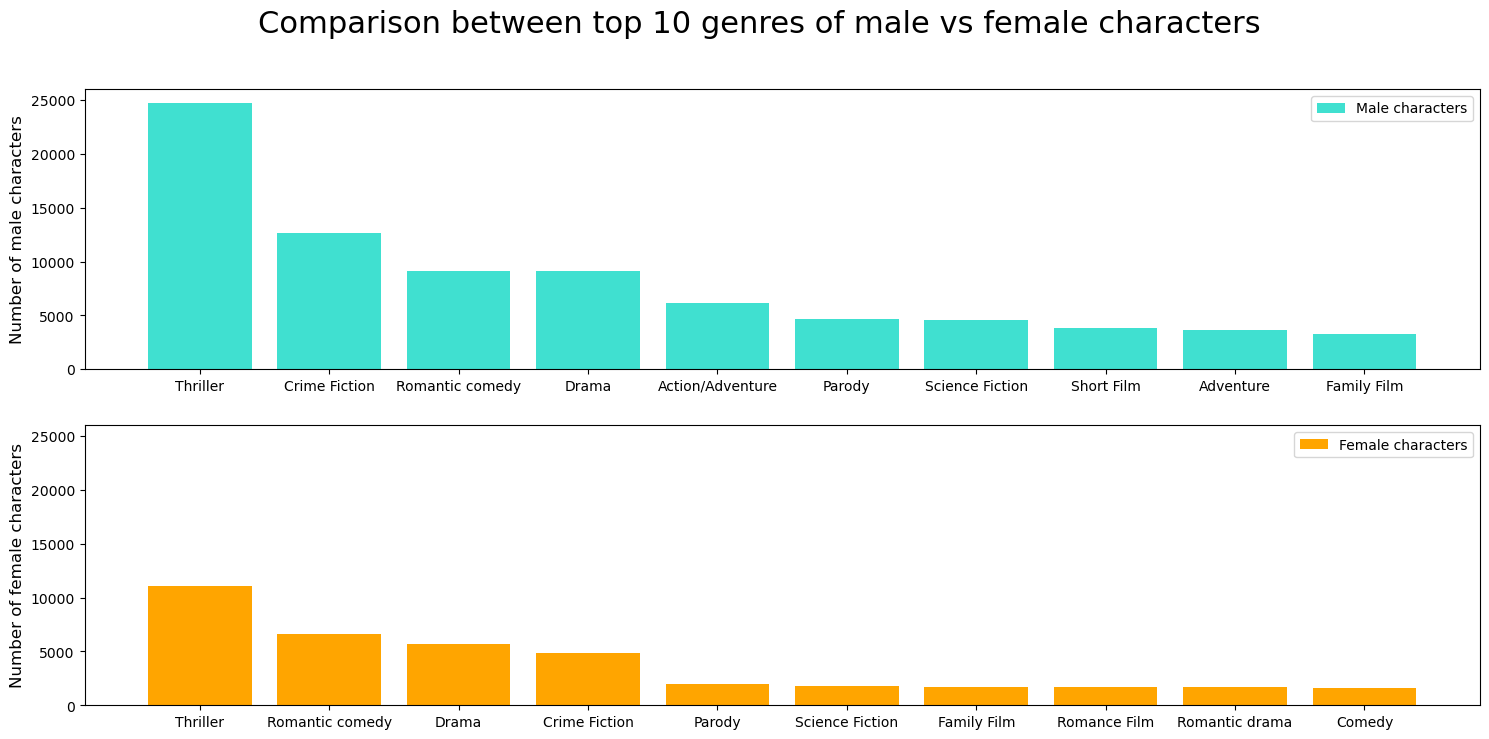

In [29]:
#Plotting top 10 genres in which male/female characters are "famous"
fig, ax = plt.subplots(2,1, figsize = (18,8), sharey = True) 

ax[0].bar(M_genre.index[0:10], M_genre['name'][0:10], label = 'Male characters', color = 'turquoise')
ax[0].legend()
ax[0].set_ylabel('Number of male characters', fontsize = 12)

ax[1].bar(F_genre.index[0:10], F_genre['name'][0:10], label = 'Female characters', color = 'orange')
ax[1].legend()
ax[1].set_ylabel('Number of female characters', fontsize = 12)
    
fig.suptitle('Comparison between top 10 genres of male vs female characters', fontsize = 22)
plt.show()

In this plot, we observe that the top 10 genres in terms of characters' appearances are different between men and women. We notice that some genres are shared such as drama, thriller and romantic comedy but others are completely absent for a certain gender. Additionally, some of the genres are very stereotypical for each gender. For example, 4 out of 10 genres for female characters are related to romance or family whereas male characters are much more present in action science fiction movies.

We wanted to focus on the evolution of the number of female and male characters in a few stereotypical genre of movies through time and see if the difference tends to decrease. For that, we chose "Action/Adventure" and "Romantic drama".

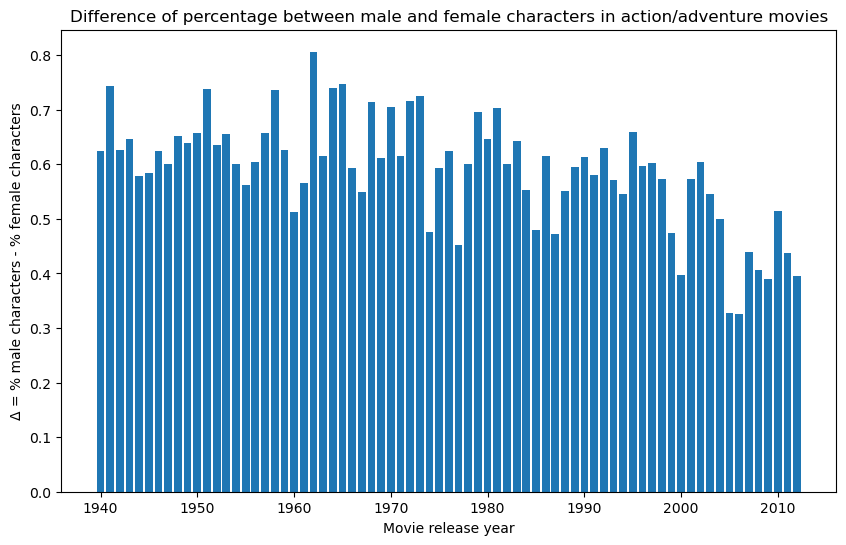

In [30]:
#Mask with only movies which have 'Action/Adventure' as main genre and grouping by year
total_act_adv = merged_charac[merged_charac['Main genre'] == 'Action/Adventure']
total_act_adv_year = total_act_adv.groupby('release_date').count()

M_action_adv = characters_M[characters_M['Main genre'] == 'Action/Adventure']
M_action_adv_year = M_action_adv.groupby('release_date').count()
M_perc_action_adv = M_action_adv_year['name']/total_act_adv_year['name']

F_action_adv = characters_F[characters_F['Main genre'] == 'Action/Adventure']
F_action_adv_year = F_action_adv.groupby('release_date').count()
F_perc_action_adv = F_action_adv_year['name']/total_act_adv_year['name']

diff_perc_action_adv = M_perc_action_adv - F_perc_action_adv

#Plotting differene between nbr of male vs female characters in 'Action/Adventure' movie through time
fig = plt.figure(figsize = (10,6), dpi = 100)

plt.bar(diff_perc_action_adv.index, diff_perc_action_adv, label = 'diff')

plt.xlabel('Movie release year')
plt.ylabel('\u0394 = % male characters - % female characters')
plt.title('Difference of percentage between male and female characters in action/adventure movies')
plt.show()

In a general manner, we observe a decreasing trend with oscillations. We observe that the number of female in action/adventure movies increase over time. 


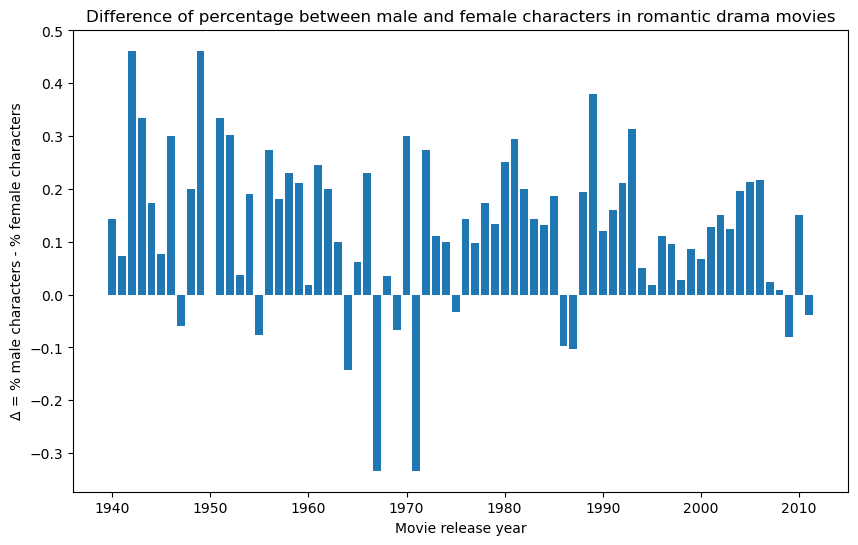

In [34]:
#Mask with only movies which have 'Romantic drama' as main genre and grouping by year
total_rom_drama = merged_charac[merged_charac['Main genre'] == 'Romantic drama']
total_rom_drama_year = total_rom_drama.groupby('release_date').count()

M_rom_drama = characters_M[characters_M['Main genre'] == 'Romantic drama']
M_rom_drama_year = M_rom_drama.groupby('release_date').count()
M_perc_rom_drama = M_rom_drama_year['name']/total_rom_drama_year['name']


F_rom_drama = characters_F[characters_F['Main genre'] == 'Romantic drama']
F_rom_drama_year = F_rom_drama.groupby('release_date').count()
F_perc_rom_drama = F_rom_drama_year['name']/total_rom_drama_year['name']

diff_perc_rom_drama = M_perc_rom_drama - F_perc_rom_drama
diff_perc_rom_drama.fillna(0)

fig = plt.figure(figsize = (10,6), dpi = 100)

#Plotting differene between nbr of male vs female characters in 'Romantic drama' movie through time
plt.bar(diff_perc_rom_drama.index, diff_perc_rom_drama)
plt.xlabel('Movie release year')
plt.ylabel('\u0394 = % male characters - % female characters')
plt.title('Difference of percentage between male and female characters in romantic drama movies')
plt.show()

Very surprisingly, even in romantic dramas where it is expected that female characters are very important and maybe even more present than men, it is not the case! Indeed, the target audience of romantic movies is typically women. Therefore, we could expect that the audience wants to be represented in the movies that they are watching. However, there is (almost) always much more male characters. With time, a small decrease of this difference seems to arise. 

Comparing the previous Action/adventure graph, here the overall difference of percentage is smaller. This can be expected as in romantic movies female characters are needed to form the couple.

# Data exploration summaries <a name="summary"></a>

## Distribution of number of words in summary
We see that the distribution is heavily skewed. Indeed, few movies have very long summaries. However, most of them have less than 1000 words.

The median number of words in the summary of all movies is 189.0


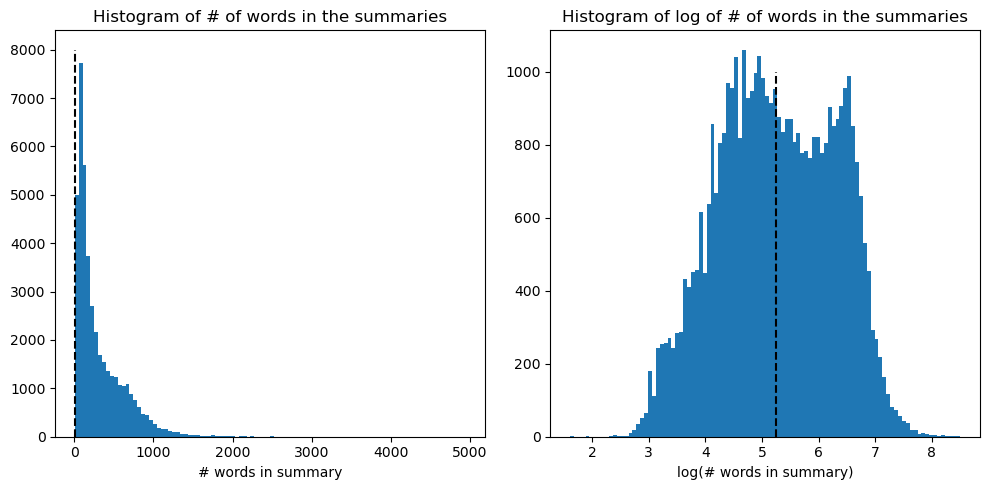

In [35]:
print('The median number of words in the summary of all movies is ' + str(summaries['length'].median()))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#Let's look at the distibution of the length of the summaries
axes[0].hist(summaries['length'],bins=100)
axes[0].vlines(np.log(summaries['length']).median(), 0,8000, linestyles='dashed',color = 'black')
axes[0].set_xlabel('# words in summary'); axes[0].set_title('Histogram of # of words in the summaries')

#The distribution is heavy tailed, apply log before binning
axes[1].hist(np.log(summaries['length']),bins=100)
axes[1].vlines(np.log(summaries['length']).median(), 0,1000, linestyles='dashed',color = 'black')
axes[1].set_xlabel('log(# words in summary)'); axes[1].set_title('Histogram of log of # of words in the summaries')

plt.tight_layout()
plt.show()

In [37]:
#Filter out summaries that are not in the set of movie of interest (USA + released after ...)
movie_interest = list(set(np.unique(summaries.index)).intersection(usa_movie.index.values))
summaries_USA = summaries.loc[movie_interest]

The median number of words in the summary of USA movies and released since 1940 is 270.0


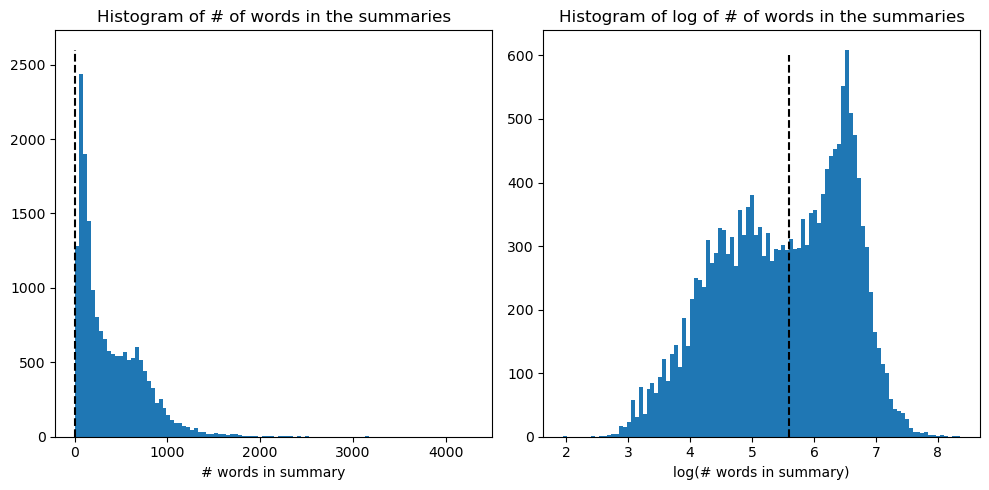

In [41]:
print('The median number of words in the summary of USA movies and released since 1940 is ' + str(summaries_USA['length'].median()))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#Let's look at the distibution of the length of the summaries
axes[0].hist(summaries_USA ['length'],bins=100)
axes[0].vlines(np.log(summaries_USA ['length']).median(), 0,2600, linestyles='dashed',color = 'black')
axes[0].set_xlabel('# words in summary'); axes[0].set_title('Histogram of # of words in the summaries')

#The distribution is heavy tailed, apply log before binning
axes[1].hist(np.log(summaries_USA ['length']),bins=100)
axes[1].vlines(np.log(summaries_USA ['length']).median(), 0,600, linestyles='dashed',color = 'black')
axes[1].set_xlabel('log(# words in summary)'); axes[1].set_title('Histogram of log of # of words in the summaries')

plt.tight_layout()
plt.show()

We observe that USA have in average longer summaries. Again, this makes sense since most English Wikipedia editors are from the USA. 

Moreover, we decide to only analyze the movies that have a summary with more than 350 words. Indeed, we want to infer the role of women in movies, but for this we need a sufficently long summary. If the summary is only a couple hundreds words long, a lot of events will be left out. Therefore, we will not be able to analyze the portrayal of women with such summaries. At the same time, we want enough number of summaries in order to have a representative sample. 


In [46]:
# select summaries having more 350 than 350 words
summaries_more_350words = summaries_USA[(summaries_USA['length'] >= 350)]

In [49]:
# Joining USA movie and summaries metadata
merged_summary = pd.merge(left = summaries_more_350words, right = usa_movie['release_date'], on = 'movie_ID', how = 'right')
#Drop movies with nan
merged_summary = merged_summary.dropna(subset = ['summary'])


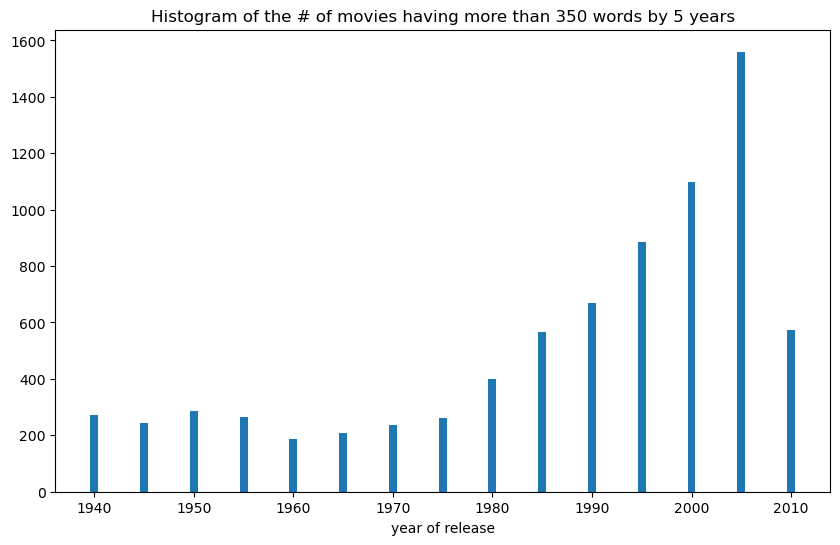

In [50]:
fig = plt.figure(figsize = (10,6), dpi = 100)
plt.bar(np.unique(merged_summary.release_date//5*5),merged_summary.groupby((merged_summary.release_date//5)*5).summary.count())
plt.xlabel('year of release'); plt.title('Histogram of the # of movies having more than 350 words by 5 years')
plt.show()

# Summary NLP analysis pipeline <a name="pipeline"></a>
1. Coreference Resolution using AllenNLP <br>
    A. Cluster all mentions of a character <br>
    B. Define the gender of each identified character 
2. Process summaries: identify named entity (NER) and tag grammatical structure (POS tagging) <br>
    A. Parse the grammatical structures of the summary <br>
    B. Extract active/passive verbs, descriptive nouns, and adjectives.

## 1. Coreference Resolution using AllenNLP model <a name="coref"></a>

1. Resolve coreference using AllenNLP deep-learning based model and modified coref_resolved function.
2. Get gender of character in coreference cluster by looking at pronouns.

The behaviour of the coref_resolved function form AllenNLP need to be modified. Indeed, it clusters all references to the same person. Then, it replaces all occurences of the same character by the first occuring reference in the cluster. However, it is often not a name, but a pronoun. In this case, it replaces all occurences with the pronoun. We want all references to be identifiable by Spacy as a named entity. So, we need to replace all occurences by the name of the character. Thus, we modified the coref_resolved function to replace by the most frequent way of referring to the character.

Note that part of the modified coref_resolved function code is from  https://github.com/NeuroSYS-pl/coreference-resolution

Furthermore, the clusters found by AllenNLP are used to define the gender of the characters. If a character is clustered with gendered pronouns, we are able to define their gender.

An example of the issues of the original function and solutions are shown below.

### Original coref_resolved fuction

In [51]:
nlp = spacy.load("en_core_web_sm")
text  = "In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker\'s son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy."

prediction = predictor.predict(document=text)
doc = nlp(text)

print('Original text: ', text)
print("")
print('Original Coref resolved: ', predictor.coref_resolved(text))

Original text:  In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker's son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy.

Original Coref resolved:  In her first Reaping, her is chosen from District 12. her's older sister Katniss volunteers to take her's place. Peeta Mellark, a baker's son who once gave Her older sister Katniss bread when Her older sister Katniss was starving, is the other District 12 tribute. Her older sister Katniss and Peeta Mellark, a baker's son who once gave Katniss bread when she was starving, are taken to the Capitol, accompanied by Katniss and Peeta's frequently drunk mentor, past victor Haymitch Abernathy.


For example, in the first sentence, "12-year-old Primrose Everdeen" is replace by "her". Furthermore, all references to "Katniss" is replace by "Her older sister Katniss". In both cases, the first mention of the character is used to replace future mentions, instead using the most common mention.

### Modified coref_resolved function and obtention of the gender

In [52]:
#Get the gender of a character from the cluster generated by the AllenNLP model.
def get_gender_from_coref(cluster, text):
    #Get text linked to indexes in cluster
    ref =  np.unique([" ".join(text[i[0]:i[1]+ 1]).lower() for i in cluster])
    
    #Define dict of gendered pronouns
    gendered_pronouns = dict([
        ('M', ['he','him','his','himself']),
        ('F', ['she','her','hers','herself'])
        ])
    
    #Check if cluster contain a gendered pronouns
    gender = ''
    if any(y == x for x in ref for y in gendered_pronouns['M']): gender = 'M'
    if any(y == x for x in ref for y in gendered_pronouns['F']): gender = 'F'
    
    return gender

In [53]:
#Order the coreference cluster by number of occurence. 
def order_coreference(cluster, text):
    #Get text linked to indexes in cluster
    ref =  pd.DataFrame([[" ".join(text[i[0]:i[1]+ 1]).lower(), i] for i in cluster])
    ref.columns = ['ref_text','ind']
    
    #Aggrate according to text, count number of occurence of each reference, and sort 
    ref = ref.groupby(ref['ref_text']).aggregate({'ref_text': 'count', 'ind': 'sum'})
    ref.index.name = None
    ref = ref.sort_values(by=['ref_text'], ascending=False) 

    
    #Order indexes in cluster
    cluster = list(chain(*ref.ind.values))
    cluster = list(zip(*(iter(cluster),) * 2))
    cluster = [list(x) for x in cluster]
    
    return cluster

In [54]:
#Fix behaviour of coref_resoltuion from AllenNLP 
#using Modified Code from https://github.com/NeuroSYS-pl/coreference-resolution

from typing import List
from spacy.tokens import Doc, Span

def core_logic_part(document: Doc, coref: List[int], resolved: List[str], mention_span: Span):
    final_token = document[coref[1]]
    #if final_token.tag_ in ["PRP$", "POS"]:
        #resolved[coref[0]] = mention_span.text + "'s" + final_token.whitespace_
    #else:
    if not(final_token.tag_ in ["PRP$", "POS"]):
        resolved[coref[0]] = mention_span.text + final_token.whitespace_
    for i in range(coref[0] + 1, coref[1] + 1):
        resolved[i] = ""
    return resolved

def get_span_noun_indices(doc: Doc, cluster: List[List[int]]) -> List[int]:
    spans = [doc[span[0]:span[1]+1] for span in cluster]
    spans_pos = [[token.pos_ for token in span] for span in spans]
    span_noun_indices = [i for i, span_pos in enumerate(spans_pos)
        if any(pos in span_pos for pos in ['NOUN', 'PROPN'])]
    return span_noun_indices

def get_cluster_head(doc: Doc, cluster: List[List[int]], noun_indices: List[int]):
    head_idx = noun_indices[0]
    head_start, head_end = cluster[head_idx]
    head_span = doc[head_start:head_end+1]
    return head_span, [head_start, head_end]

def is_containing_other_spans(span: List[int], all_spans: List[List[int]]):
    return any([s[0] >= span[0] and s[1] <= span[1] and s != span for s in all_spans])

def improved_replace_corefs(document, clusters, text):
    resolved = list(tok.text_with_ws for tok in document)
    all_spans = [span for cluster in clusters for span in cluster]  # flattened list of all spans

    character = []
    for cluster in clusters:
        noun_indices = get_span_noun_indices(document, cluster)
        
        #Check if cluster contains gendered pronouns
        cluster_gender = get_gender_from_coref(cluster, text)

        if noun_indices:
            mention_span, mention = get_cluster_head(document, cluster, noun_indices)
            
            for coref in cluster:
                if coref != mention and not is_containing_other_spans(coref, all_spans):
                    core_logic_part(document, coref, resolved, mention_span)
            
            #Put in character dataframe all mention that are gendered
            if not(cluster_gender == ""):
                character.append([" ".join(text[mention[0]:mention[1]+ 1]).lower(), cluster_gender])
                
                    
    return "".join(resolved), character

In [55]:
clusters = list(pd.Series(prediction['clusters']).apply(order_coreference, args=(prediction['document'],)))
doc = nlp(text)

print('Original text: ', text)
print("")
coref_text, character = improved_replace_corefs(doc, clusters, prediction['document'])
print('Modified Coref resolved: ', coref_text)

Original text:  In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker's son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy.

Modified Coref resolved:  In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker's son who once gave Katniss bread when Katniss was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy.


### Example of application on a full summary

In [56]:
#Full coreference resolution pipeline 
def coreference_resolution(text, nlp_pipeline, predictor):
    prediction = predictor.predict(document=text) 
    clusters = list(pd.Series(prediction['clusters']).apply(order_coreference, args=(prediction['document'],)))
    
    doc = nlp_pipeline(text)
    
    coref_text, character = improved_replace_corefs(doc, clusters, prediction['document'])
    character = pd.DataFrame(character, columns=['name','gender'])
    
    return coref_text, character

In [57]:
nlp = spacy.load("en_core_web_sm")
model_url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz"
predictor = Predictor.from_path(model_url)

text = summaries.loc[31186339].summary
coref_summary, coref_character = coreference_resolution(text, nlp, predictor)
coref_character

error loading _jsonnet (this is expected on Windows), treating C:\Users\alexi\AppData\Local\Temp\tmptjc3jb_p\config.json as plain json
C:\Users\alexi\anaconda3\lib\site-packages\allennlp\modules\token_embedders\pretrained_transformer_embedder.py:385: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  num_effective_segments = (seq_lengths + self._max_length - 1) // self._max_length


,name,gender
0,12 - year - old primrose everdeen,F
1,katniss,F
2,peeta,M
3,haymitch,M
4,rue,F
5,president snow,M
6,clove,F
7,thresh,M
8,"foxface , the girl from district 5 ,",F
9,cato,M


## 2. Process summaries: identify named entity (NER) and tag grammatical structure (POS tagging) <a name="NER"></a>



### Using the NER module from spacy

On its own, the NER module from spacy misses a lot of characters and their mentions. In total, there is 116 mentions of characters in the text, but only 31 are found by spacy.

In [59]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(coref_summary)
    
print('Spacy found ' + str(len([(X.text, X.label_) for X in doc.ents if X.label_== 'PERSON' ])) + ' mentions of characters.')

Spacy found 31 mentions of characters.


### Improvement of the identification of named entities

To improve the accuracy, we add an entity ruler to spacy with all character names. Each custom name set provided to spacy is specific to each movie to avoid confusion.

First, we complete the metadata with the additional characters found by coreference resolution. Then, we generate all possible combinations of the characters names using first and last names. It hands it to the entity_ruler module of spacy. <br>
To evaluate the accuracy of the names entity finder, we counted manually the number of mentions. The total amounts to 116 words. Spacy finds 115 mentions, thus, it has an accuracy of 99%. Indeed, missing one word is a mistake that even a human could make.

### Add additional characters to metadata

In [60]:
def find_whole_word(string:str,list_words:list):
    return any(y == x for x in string.lower().split() for y in list_words)

def check_coref_in_metadata(coref_charac, metadata):
    return pd.Series({'name': coref_charac, 'ind': np.where(metadata.apply(lambda row : find_whole_word(coref_charac, row.unique_name), axis=1))[0]})

#Add to metadata character found by coreference resolution
def add_character_from_coref(coref, metadata):
    
    split_name = [x.lower().split() for x in metadata.name]
    unique_names = list(chain(*split_name))
    
    character_to_add = np.logical_not(list(coref['name'].apply(find_whole_word, args=(unique_names, ))))
    character_to_add = pd.DataFrame(coref[character_to_add])
    character_to_add.name = [x.split(', ')[0] for x in character_to_add.name]
    
    return character_to_add

In [61]:
character = character_metadata.loc[31186339][:]

to_add = add_character_from_coref(coref_character,character)
character = pd.concat([character, to_add], sort=False)

to_add

,name,gender
7,thresh,M
8,foxface,F


### Add entity ruler with all character name

Create patterns for the entity_ruler from character metadata

In [62]:
#Create pattern from character list
def get_patterns(character):
    patterns = []
    for c in character.name:
        split_name = c.lower().split()
        for i in split_name:
             patterns.append({"label": "PERSON", "pattern": [{"LOWER": i.lower()}], "id": c})
        if (len(split_name) > 1):
            patterns.append(({"label": "PERSON", "pattern": [{"LOWER": split_name[0].lower()},{"LOWER": split_name[1].lower()}], "id": c}))
    return patterns

In [63]:
def add_character_entity_ruler_to_nlp(nlp, character):
    ruler = nlp.add_pipe("entity_ruler", before ='ner')
    nlp.add_pipe("merge_entities")

    patterns = get_patterns(character)

    ruler.add_patterns(patterns)
    
    return nlp

### Example of application on a full summary

In [64]:
nlp = spacy.load("en_core_web_sm")
nlp = add_character_entity_ruler_to_nlp(nlp, character)
character = character.set_index('name')

In [65]:
doc_summary = nlp(coref_summary)

'Spacy found ' + str(len([(X.text, X.label_) for X in doc_summary.ents if X.label_== 'PERSON' ])) + ' mentions of characters.'

'Spacy found 115 mentions of characters.'

## Finally, we can now run the summary trough the nlp pipeline! To get the verbs and adjectives associated with the characters.

Spacy identifies the characters in the text and tags the grammatical structure of the summary. Below, one can see an example of such tagging. Active verbs are defined as verb linked to a character by 'nsubj' or 'agent' tag, whereas, the passive verbs are linked via the 'nsubjpass' and 'dobj' tags. The descriptive nouns and adjectives defining the characters in the text are extracted by looking at the 'amod', 'compound', 'attr, 'and 'apos' tags. <br>

Below is an example of the POS parsing done by spacy on the first few sentences of a summary. The code extracting the active/passive verbs, descriptive nouns, and adjectives still need to be expected, but we present a example of the intended output.

In [66]:
text =  "In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister, Katniss, volunteers to take her place. Peeta Mellark, a baker\'s son who once gave Katniss bread when Katniss was starving, is the other District 12 tribute. Katniss and Peeta are taken to a wealthy Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy."
doc = nlp(text)
    
spacy.displacy.render(doc, style='dep')

In [67]:
named_ent = [X.text if X.id_ == '' else X.id_ for X in doc.ents if X.label_== 'PERSON' ]

#Get count of mentions of character in summary
c, counts = np.unique(named_ent, return_counts = True)
df = pd.DataFrame(counts, index = c, columns=['mention'])
df = df.sort_values(by=['mention'], ascending=False)
df['active_verb'] = [['volunteer', 'starve'],['give'],['accompany'],[]]
df['passive_verb'] = [['give','take','accompany'],['take', 'accompany'],[],['choose']]
df['description'] = [['older sister'],["baker's son", 'other District 12 tribute'],['frequently drunk mentor', 'past victor'],['12-year-old']]

df

,mention,active_verb,passive_verb,description
Katniss Everdeen,4,"[volunteer, starve]","[give, take, accompany]",[older sister]
Peeta Mellark,2,[give],"[take, accompany]","[baker's son, other District 12 tribute]"
Haymitch Abernathy,1,[accompany],[],"[frequently drunk mentor, past victor]"
Primrose Everdeen,1,[],[choose],[12-year-old]


### Let's merge the info from spacy with the character metadata

In [68]:
df = pd.merge(df,character, how='left', left_index=True, right_index=True)
df

,mention,active_verb,passive_verb,description,release_date,gender,age
Katniss Everdeen,4,"[volunteer, starve]","[give, take, accompany]",[older sister],2012.0,F,21.0
Peeta Mellark,2,[give],"[take, accompany]","[baker's son, other District 12 tribute]",2012.0,M,19.0
Haymitch Abernathy,1,[accompany],[],"[frequently drunk mentor, past victor]",2012.0,M,50.0
Primrose Everdeen,1,[],[choose],[12-year-old],2012.0,F,11.0
